[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/blob/main/03b_BERT-classifier_Keras.ipynb)

## Trial: Using BERT with Keras

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import tensorflow as tf

os.makedirs('10kGNAD', exist_ok=True) # create folder in Colab

In [2]:
# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

In [3]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])


# use the LabelEncoder vom sklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

df_train["label_id"] = df_train.label.map(label_to_id)
df_test["label_id"] = df_test.label.map(label_to_id)

print("\nShapes:", df_train.shape, df_test.shape)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}

Shapes: (9245, 3) (1028, 3)


### The Huggingface Transformer library

In [4]:
!pip install transformers

### Note: Using Transformers with Tensorflow/Keras

You can use the transformers library with Tensorflow/Keras but - as far as I know/think - the main support and documentation/tutorials is with PyTorch in mind. There might be some features/models that are not available for Tensorflow.
For tasks such as basic text classifiation though, it works fine.

We will use the model `TFAutoModelForSequenceClassification` and load the German checkpoint.

`Auto` means that the architecture of the model is automatically inferred by the loaded checkpoint. `TF` stands for the Tensrflow model implementation (so that `model.train` works etc.). `SequenceClassification` again is the task and so defines the architecture of the output layer on top of BERT, here: A Dropout layer and a dense layer for classification.

In [5]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

checkpoint = 'bert-base-german-cased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
tokenizer.tokenize("Bert kann ganz tolle Dinge. Und trennt zusammengesetzte Wörter.") # just tokenizing, no special tokens, no input_ids and no padding

['Bert',
 'kann',
 'ganz',
 'toll',
 '##e',
 'Dinge',
 '.',
 'Und',
 'trennt',
 'zusammenge',
 '##setzte',
 'Wörter',
 '.']

In [7]:
inputs = tokenizer(["Dieser Satz ist lang, denn er soll länger sein als der zweite.",
                    "Okay, alles klar."],
                   return_tensors="tf",
                   padding=True, # default ist to pad to longest sequence
                   truncation=True,
                   return_token_type_ids = False)
inputs.keys()

print(inputs["input_ids"])               # note the special tokens 3 (CLS) and 4 (SEP)
print(inputs["attention_mask"])

tf.Tensor(
[[    3  2280  1102   127  1489 26918  1803    67   459  3530   167   153
     21  2961 26914     4]
 [    3 10459   680 26918  2368  3550 26914     4     0     0     0     0
      0     0     0     0]], shape=(2, 16), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]], shape=(2, 16), dtype=int32)


In [8]:
# load the model with pretrained weights
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, 
                                                             num_labels=9)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# small look at layer names
for l in model.layers:
    print(l.name)

bert
dropout_37
classifier


In [10]:
# in case we want to freeze the BERT components

FREEZE_BERT = False
#FREEZE_BERT = True

if FREEZE_BERT:
    model.get_layer('bert').trainable = False

In [11]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109081344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 109,088,265
Trainable params: 109,088,265
Non-trainable params: 0
_________________________________________________________________


In [12]:
# have a look at what the output looks like: logits
model(**inputs)

TFSequenceClassifierOutput([('logits',
                             <tf.Tensor: shape=(2, 9), dtype=float32, numpy=
                             array([[-0.30834952,  0.14544165, -0.50206876,  0.06036234,  0.3212133 ,
                                     -0.06753956, -0.03966609,  0.2820257 ,  0.02538531],
                                    [-0.42566147,  0.12109683, -0.450768  , -0.07629523,  0.4075837 ,
                                      0.08671694, -0.24419749,  0.15376823,  0.11393366]],
                                   dtype=float32)>)])

### Create dataset with `tf.data.Dataset.from_tensor_slices`

In [13]:
MAX_LENGTH = 128

In [14]:
train_tokenized = tokenizer(list(df_train.article), 
                            return_tensors="tf", 
                            padding="max_length", 
                            max_length = MAX_LENGTH,
                            truncation=True)

test_tokenized = tokenizer(list(df_test.article), 
                            return_tensors="tf", 
                            padding="max_length", 
                            max_length = MAX_LENGTH,
                            truncation=True)

In [15]:
train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
train_tokenized["input_ids"].shape

TensorShape([9245, 128])

In [17]:
y_train = df_train.label_id.values
y_test = df_test.label_id.values
print(y_train.shape, y_test.shape)

# make labels into matrix
#from tensorflow.keras.utils import to_categorical
#y_train_matrix = to_categorical(y_train, dtype ="int")
#y_test_matrix = to_categorical(y_test, dtype ="int")
#print(y_train_matrix.shape, y_dev_matrix.shape, y_test_matrix.shape)

(9245,) (1028,)


In [18]:
y_train

array([5, 3, 6, ..., 7, 1, 4])

In [19]:
#y_train_matrix

In [20]:
BATCH_SIZE = 8

train_features = {x: train_tokenized[x] for x in ["input_ids", "attention_mask"] }                        # take the inputs you need for the model (e.g we dont need "token_type_ids" )
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, y_train)).batch(BATCH_SIZE)        # make a tf.Dataset (batched) from features and labels (this is very TensorFlow-ish, and new to me)

test_features = {x: test_tokenized[x] for x in ["input_ids", "attention_mask"] }
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, y_test)).batch(BATCH_SIZE)

In [21]:
list(train_tf_dataset.as_numpy_iterator())[0] # look at one input (one batch with model inputs (features) and target labels)

({'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32),
  'input_ids': array([[    3,  2439, 26935, ...,     0,     0,     0],
         [    3, 13190,   592, ...,    88,  9402,     4],
         [    3,   233, 17580, ..., 26914,   831,     4],
         ...,
         [    3,   233,  5656, ..., 26445, 26918,     4],
         [    3,  5999,   575, ...,     0,     0,     0],
         [    3,  1747,  4442, ...,   178,    86,     4]], dtype=int32)},
 array([5, 3, 6, 7, 1, 7, 5, 0]))

In [22]:
len(train_tf_dataset), len(test_tf_dataset) # batches

(1156, 129)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

In [24]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109081344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 109,088,265
Trainable params: 109,088,265
Non-trainable params: 0
_________________________________________________________________


In [25]:
for l in model.layers:
    print(l.name, l.trainable)

bert True
dropout_37 True
classifier True


In [26]:
hist = model.fit(train_tf_dataset.take(100), # NOTE: for time reasons, like in the PyTorch notebook, we only use N batches of course in real life DON'T do this!
                 validation_data=test_tf_dataset,
                 epochs=10)

Epoch 1/10
100/100 [==============================] - 113s 905ms/step - loss: 1.4486 - sparse_categorical_accuracy: 0.5575 - val_loss: 0.7661 - val_sparse_categorical_accuracy: 0.8152
Epoch 2/10
100/100 [==============================] - 87s 872ms/step - loss: 0.5064 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.5739 - val_sparse_categorical_accuracy: 0.8298
Epoch 3/10
100/100 [==============================] - 87s 871ms/step - loss: 0.2123 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.5038 - val_sparse_categorical_accuracy: 0.8551
Epoch 4/10
100/100 [==============================] - 87s 872ms/step - loss: 0.0954 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.6082 - val_sparse_categorical_accuracy: 0.8356
Epoch 5/10
100/100 [==============================] - 87s 871ms/step - loss: 0.0509 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.5693 - val_sparse_categorical_accuracy: 0.8541
Epoch 6/10
100/100 [==============================] - 87s 872ms/step - loss: 0.0449 

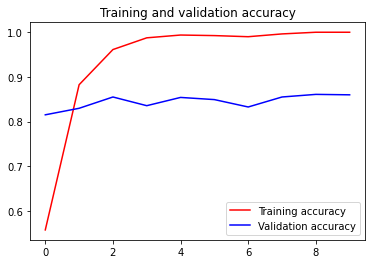

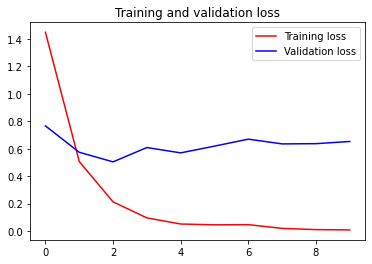

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
acc = hist.history['sparse_categorical_accuracy']
val_acc = hist.history['val_sparse_categorical_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()